In [1]:
import polars as pl
import numpy as np
import plotly.express as px
from itertools import product

In [28]:
ex = pl.DataFrame(
    {
        "a": ["a", "b", "a", "b", "c"],
        "b": [1, 2, 1, 3, 3],
        "c": [5, 4, 3, 2, 1],
    }
)

In [29]:
ex

a,b,c
str,i64,i64
"""a""",1,5
"""b""",2,4
"""a""",1,3
"""b""",3,2
"""c""",3,1


In [43]:
cartesian_product = list(product(range(maxes["x"][0] + 1), range(maxes["y"][0] + 1), range(4)))

# Create a DataFrame from the Cartesian product
xys = pl.DataFrame({
    "t": [z for x, y, z in cartesian_product],
    "x": [x for x, y, z in cartesian_product],
    "y": [y for x, y, z in cartesian_product]
}).sort("t", "x", "y")

xys.columns, xys.shape

(['t', 'x', 'y'], (19392000, 3))

In [20]:
4848000*4

19392000

In [2]:
df = pl.read_parquet("/var/folders/jx/54tww2ls58n8qtlp9k31nbd80000gp/T/flyte9ceix9my/user_space_or0976i/results.parquet")

In [39]:
df.head(), df.shape

(shape: (5, 3)
 ┌───────┬───────────────┬───────────────────┐
 │ epoch ┆ coordinates   ┆ color             │
 │ ---   ┆ ---           ┆ ---               │
 │ i64   ┆ array[i64, 2] ┆ array[i32, 4]     │
 ╞═══════╪═══════════════╪═══════════════════╡
 │ 0     ┆ [1401, 384]   ┆ [104, 98, … 129]  │
 │ 0     ┆ [1403, 112]   ┆ [202, 195, … 93]  │
 │ 0     ┆ [2000, 1420]  ┆ [131, 126, … 126] │
 │ 0     ┆ [2230, 900]   ┆ [191, 188, … 90]  │
 │ 0     ┆ [722, 1092]   ┆ [202, 200, … 80]  │
 └───────┴───────────────┴───────────────────┘,
 (19391232, 3))

In [44]:
named = df.select(
    t=pl.col("epoch"),
    x=pl.col("coordinates").arr.first(),
    y=pl.col("coordinates").arr.last(),
    c=pl.col("color"),
).sort("t", "x", "y")

In [37]:
xys.columns, named.columns

(['t', 'x', 'y'], ['t', 'x', 'y', 'c'])

In [45]:
joined = xys.join(named, on=["t", "x", "y"], how="left", coalesce=True)

In [11]:
joined.dtypes

[Int64, Int64, Int64, Array(Int32, shape=(4,))]

In [46]:
joined.null_count()

t,x,y,c
u32,u32,u32,u32
0,0,0,768


In [41]:
joined.shape

(19392000, 4)

In [42]:
joined.sample()

t,x,y,c
i64,i64,i64,"array[i32, 4]"
426,2264,426,null


In [47]:
filled = joined.fill_null(strategy="forward")

In [48]:
final = filled.sort("t", "x", "y").group_by("t", "x").agg("c").sort("t", "x").group_by("t").agg("c").get_column("c")

In [49]:
final

c
"list[list[array[i32, 4]]]"
"[[[180, 174, … 130], [179, 173, … 127], … [181, 175, … 128]], [[191, 185, … 120], [193, 189, … 116], … [194, 189, … 116]], … [[190, 184, … 104], [190, 185, … 103], … [178, 172, … 108]]]"
"[[[155, 149, … 150], [161, 155, … 142], … [142, 136, … 160]], [[171, 164, … 136], [173, 166, … 133], … [174, 168, … 126]], … [[155, 152, … 90], [170, 166, … 91], … [165, 161, … 90]]]"
"[[[187, 181, … 129], [195, 190, … 116], … [165, 158, … 149]], [[189, 183, … 128], [197, 192, … 115], … [169, 161, … 141]], … [[174, 169, … 99], [183, 177, … 94], … [149, 143, … 120]]]"
"[[[180, 173, … 129], [191, 185, … 115], … [175, 169, … 120]], [[185, 178, … 124], [194, 187, … 115], … [179, 173, … 115]], … [[164, 161, … 103], [175, 172, … 94], … [156, 153, … 108]]]"


In [50]:
shapes = [x.shape for x in final[0]]
set(shapes)

{(2020,)}

In [12]:
xx = df.select(
    t=pl.col("epoch"),
    x=pl.col("coorbdinates").arr.first(),
    y=pl.col("coordinates").arr.last(),
    c=pl.col("color"),
).sort("t", "x", "y").group_by("t", "x").agg("c").sort("t", "x").group_by("t").agg("c").get_column("c")

In [6]:
maxes = named.select(pl.max("x"), pl.max("y"))
maxes

x,y
i64,i64
2399,2019


In [93]:
maxes["x"][0]

4031

In [24]:
xx = df.select(
    t=pl.col("epoch"),
    x=pl.col("coordinates").arr.first(),
    y=pl.col("coordinates").arr.last(),
    c=pl.col("color"),
).sort("t", "x", "y").group_by("t", "x").agg("c").sort("t", "x").group_by("t").agg("c")

In [27]:
xx

t,c
i64,"list[list[array[i32, 3]]]"
0,"[[[131, 131, 126], [132, 132, 127], … [136, 136, 131]], [[128, 127, 122], [129, 129, 124], … [137, 137, 132]], … [[130, 130, 126], [131, 131, 126], … [136, 136, 131]]]"


In [20]:
shapes = [x.shape for x in xx[0]]

In [22]:
set(shapes)

{(2266,), (2267,), (2268,)}

In [23]:
2268*4032

9144576

In [5]:
animation = np.array(
    df
    .select(
        t=pl.col("epoch"),
        x=pl.col("coordinates").arr.first(),
        y=pl.col("coordinates").arr.last(),
        c=pl.col("color"),
    )
    .sort("t", "x", "y")
    .group_by("t", "x")
    .agg('c')
    .sort("t", "x")
    .group_by("t")
    .agg("c")
    .get_column("c")
    .to_list()
)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 4032) + inhomogeneous part.

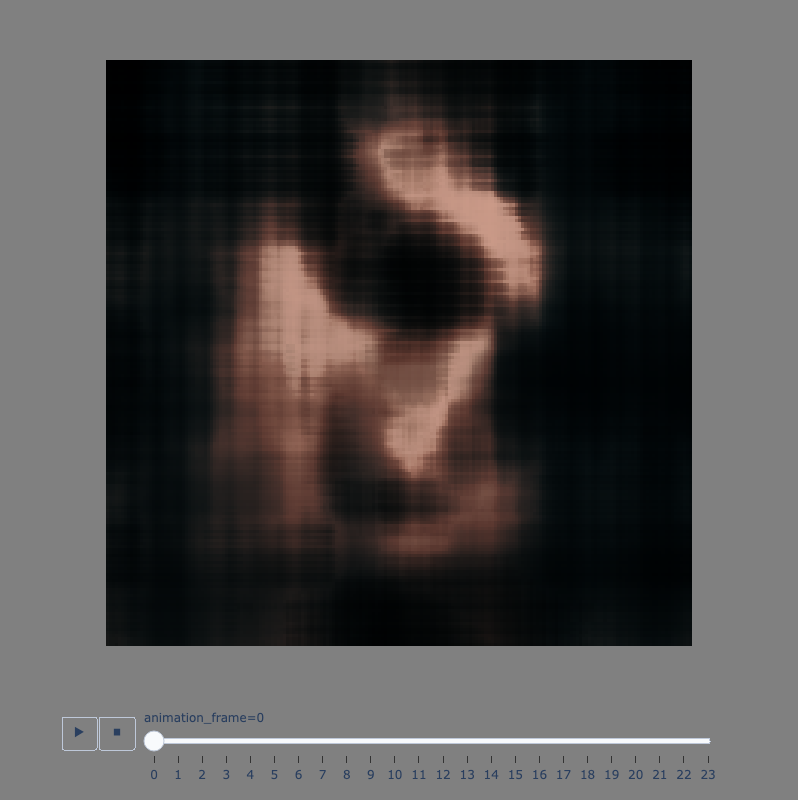

In [5]:
fig = px.imshow(
    animation,
    animation_frame=0,
    binary_string=True,
    binary_compression_level=9,
    zmax=[255, 255, 255]
)

fig.update_layout(
    coloraxis_showscale=False,
    height=800,
    paper_bgcolor="gray",
    hovermode=False
)
fig.update_xaxes(showticklabels=False, fixedrange=True)
fig.update_yaxes(showticklabels=False, fixedrange=True)

fig.show(config={ 'modeBarButtonsToRemove': ['zoom', 'pan'] })

In [7]:
(2**8)-1

255

In [64]:
a = pl.DataFrame(
    {
        "foo": [1, 2, 3],
        "bar": [6.0, 7.0, 8.0],
        "ham": ["a", "b", "c"],
    }
)
b = pl.DataFrame(
    {
        "apple": ["x", "y", "z"],
        "ham": ["a", "b", "d"],
    }
)
a.join(b, on="ham", how="full", coalesce=True)

foo,bar,ham,apple
i64,f64,str,str
1,6.0,"""a""","""x"""
2,7.0,"""b""","""y"""
null,null,"""d""","""z"""
3,8.0,"""c""",null
